In [72]:
import pandas as pd
from my_awesome_eda import run_eda
import matplotlib.pyplot as plt
import seaborn as sns
import random
import numpy as np
from tabulate import tabulate
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error, roc_auc_score)
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import svm
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.svm import SVC

In [35]:
SEED = 111
random.seed(SEED)
np.random.seed(SEED)

In [36]:
test = pd.read_csv('./test.csv').drop(['Unnamed: 0', 'id'], axis=1)
train = pd.read_csv('./train.csv').drop(['Unnamed: 0', 'id'], axis=1)
print(f"Размерность датасета: {train.shape}")

Размерность датасета: (103904, 23)


In [37]:
train.head()
#satisfaction - целевая переменная

,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,Ease of Online booking,Gate location,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,3,1,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,Male,disloyal Customer,25,Business travel,Business,235,3,2,3,3,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,Female,Loyal Customer,26,Business travel,Business,1142,2,2,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,Female,Loyal Customer,25,Business travel,Business,562,2,5,5,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,Male,Loyal Customer,61,Business travel,Business,214,3,3,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


In [38]:
#Проверим пропущенные значения
print(np.sum(train.isna(), axis=0))
print(np.sum(test.isna(), axis=0))
train_filt = train.dropna()
test_filt = test.dropna()

Gender                                 0
Customer Type                          0
Age                                    0
Type of Travel                         0
Class                                  0
Flight Distance                        0
Inflight wifi service                  0
Departure/Arrival time convenient      0
Ease of Online booking                 0
Gate location                          0
Food and drink                         0
Online boarding                        0
Seat comfort                           0
Inflight entertainment                 0
On-board service                       0
Leg room service                       0
Baggage handling                       0
Checkin service                        0
Inflight service                       0
Cleanliness                            0
Departure Delay in Minutes             0
Arrival Delay in Minutes             310
satisfaction                           0
dtype: int64
Gender                                0
Cust

In [39]:
#ОПИСЫВАЕМ ДАТАСЕТЫ
space = ' '
number_column_train, number_row_train = len(train_filt.columns), len(train_filt)
number_column_test, number_row_test = len(test_filt.columns), len(test_filt)
print(
    f'\033[1;32m1) Number of columns (train):\033[0;0m {number_column_train},\n{space * 1}\033[1;32m Number of columns (train):\033[0;0m {number_row_train}\n')

print(
    f'{space * 2}\033[1;32mNumber of columns (test):\033[0;0m {number_column_test},\n{space * 1}\033[1;32m Number of columns (test):\033[0;0m {number_row_test}\n')

# Identify dtype
column_list_num = []
column_list_category = []
column_list_str = []

for column in train.columns:
    if train[column].dtype == float:
        column_list_num.append(column)
    elif train[column].dtype == int:
        if train[column].nunique() >= 8:
            column_list_num.append(column)
        else:
            column_list_category.append(column)
    elif train[column].dtype == str:
        if train[column].nunique() >= 8:
            column_list_str.append(column)
        else:
            column_list_category(column)
    else:
        if train[column].nunique() >= 8:
            column_list_str.append(column)
        else:
            column_list_category.append(column)

print(f'\033[1;31m2) Numerical columns:\033[0;0m {column_list_num},')
print(f"{space * 2}\033[1;31m String columns:\033[0;0m {column_list_str},")
print(f"{space * 2}\033[1;31m Categorical columns:\033[0;0m  {column_list_category}\n")

print(f"Количество числовых колонок: {len(column_list_num)}")
print(f"Количество категориальных колонок: {len(column_list_category)}")

1) Number of columns (train): 23,
  Number of columns (train): 103594

  Number of columns (test): 23,
  Number of columns (test): 25893

2) Numerical columns: ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes'],
   String columns: [],
   Categorical columns:  ['Gender', 'Customer Type', 'Type of Travel', 'Class', 'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness', 'satisfaction']

Количество числовых колонок: 4
Количество категориальных колонок: 19


In [40]:
#НАДО ПОНЯТЬ КАКИЕ СТОЛБЫ КАТЕГОРИАЛЬНЫЕ, А КАКИЕ НЕТ
train_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Gender                             103594 non-null  object 
 1   Customer Type                      103594 non-null  object 
 2   Age                                103594 non-null  int64  
 3   Type of Travel                     103594 non-null  object 
 4   Class                              103594 non-null  object 
 5   Flight Distance                    103594 non-null  int64  
 6   Inflight wifi service              103594 non-null  int64  
 7   Departure/Arrival time convenient  103594 non-null  int64  
 8   Ease of Online booking             103594 non-null  int64  
 9   Gate location                      103594 non-null  int64  
 10  Food and drink                     103594 non-null  int64  
 11  Online boarding                    103594 no

In [41]:
for col in column_list_category:
    train_filt[col] = train_filt[col].astype('category')
    test_filt[col] = test_filt[col].astype('category')

/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_20644/465958487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_filt[col] = train_filt[col].astype('category')
/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_20644/465958487.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_filt[col] = test_filt[col].astype('category')
/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_20644/465958487.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [42]:
train_filt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 103594 entries, 0 to 103903
Data columns (total 23 columns):
 #   Column                             Non-Null Count   Dtype   
---  ------                             --------------   -----   
 0   Gender                             103594 non-null  category
 1   Customer Type                      103594 non-null  category
 2   Age                                103594 non-null  int64   
 3   Type of Travel                     103594 non-null  category
 4   Class                              103594 non-null  category
 5   Flight Distance                    103594 non-null  int64   
 6   Inflight wifi service              103594 non-null  category
 7   Departure/Arrival time convenient  103594 non-null  category
 8   Ease of Online booking             103594 non-null  category
 9   Gate location                      103594 non-null  category
 10  Food and drink                     103594 non-null  category
 11  Online boarding                

In [43]:
freq = []
data_for_table = []
print(f'\033[1;36mNumber of values and their frequencies:\033[1;0m\n')

for column in column_list_category:
    value_list = train[column].value_counts().index
    value_count_list = train[column].value_counts().values
    freq_list = list(map(lambda x: x / value_count_list.sum(), value_count_list))

    for value, value_count, freq in zip(value_list, value_count_list, freq_list):
        data_for_table.append([value, value_count, round(freq, 3)])
    print(f"\033[1;36m{column}\033[0;0m")
    print(tabulate(data_for_table, headers=['Name', 'Count', 'Frequences'], tablefmt='rounded_outline') + '\n')
    data_for_table.clear()

Number of values and their frequencies:

Gender
╭────────┬─────────┬──────────────╮
│ Name   │   Count │   Frequences │
├────────┼─────────┼──────────────┤
│ Female │   52727 │        0.507 │
│ Male   │   51177 │        0.493 │
╰────────┴─────────┴──────────────╯

Customer Type
╭───────────────────┬─────────┬──────────────╮
│ Name              │   Count │   Frequences │
├───────────────────┼─────────┼──────────────┤
│ Loyal Customer    │   84923 │        0.817 │
│ disloyal Customer │   18981 │        0.183 │
╰───────────────────┴─────────┴──────────────╯

Type of Travel
╭─────────────────┬─────────┬──────────────╮
│ Name            │   Count │   Frequences │
├─────────────────┼─────────┼──────────────┤
│ Business travel │   71655 │         0.69 │
│ Personal Travel │   32249 │         0.31 │
╰─────────────────┴─────────┴──────────────╯

Class
╭──────────┬─────────┬──────────────╮
│ Name     │   Count │   Frequences │
├──────────┼─────────┼──────────────┤
│ Business │   49665 │        0.

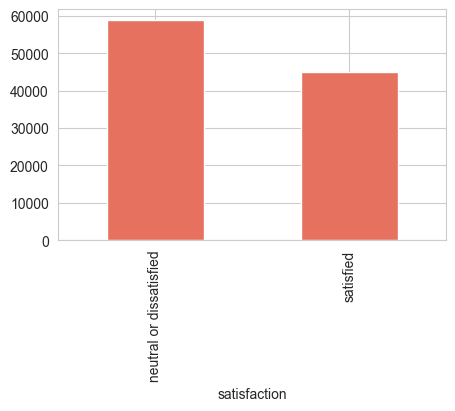

In [44]:
#Рисуем баланс классов у целевой переменной
plt.figure(figsize=(5, 3))
train['satisfaction'].value_counts().plot(kind='bar', color=sns.color_palette("flare", n_colors=3)[0]);
#Видим, что класса False в несколько раз больше чем True (Это неприятно, дальше решим, что с этим делать)

In [45]:
len(train_filt['satisfaction'].value_counts())

2

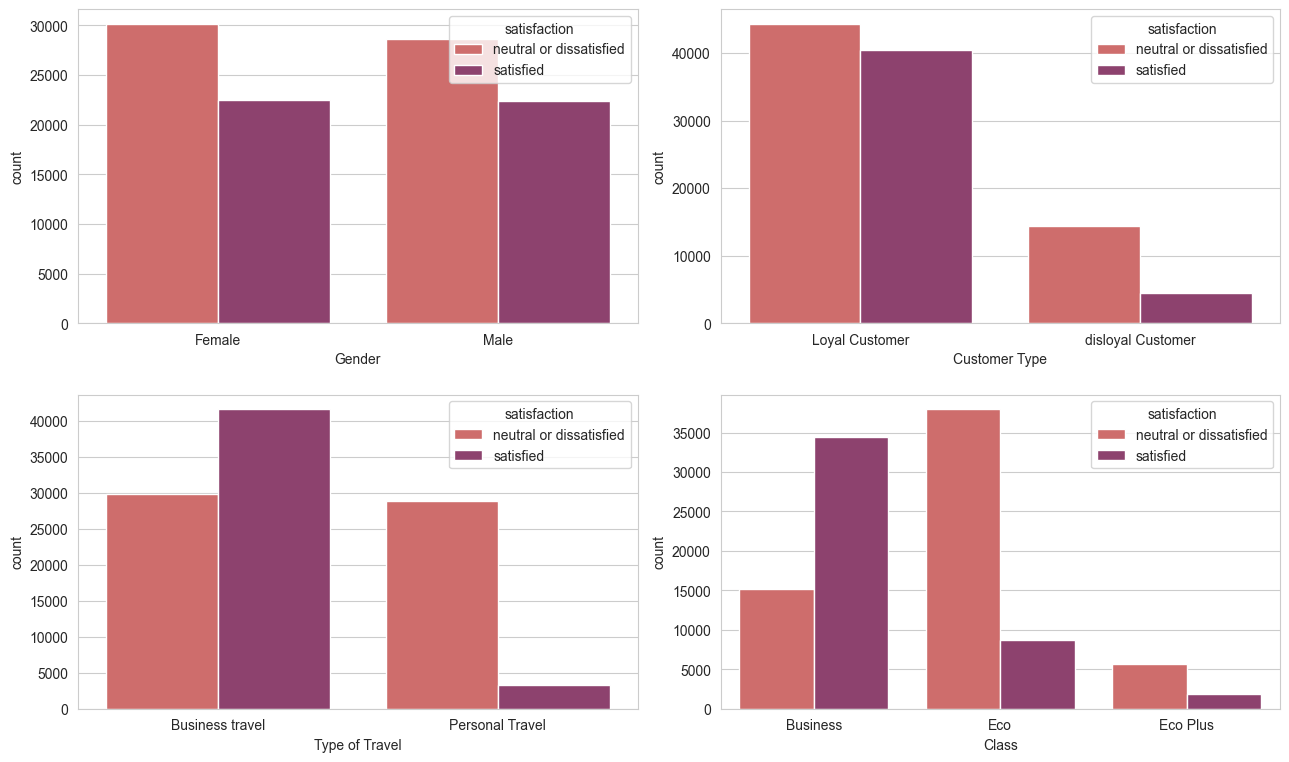

In [46]:
#Смотрим на связь между целевой переменной и другими фичами
plt.figure(figsize=(13, 15))

for i, col in enumerate(column_list_category[:-1]):
    if len(train_filt[col].value_counts()) < 4:
        plt.subplot(4, 2, i + 1)
        sns.countplot(x=col, hue="satisfaction", data=train_filt, palette=sns.color_palette("flare", n_colors=2))
    plt.tight_layout(h_pad=2)

#Видим, что в целом все факторы играют какую-то роль

<Figure size 640x480 with 0 Axes>

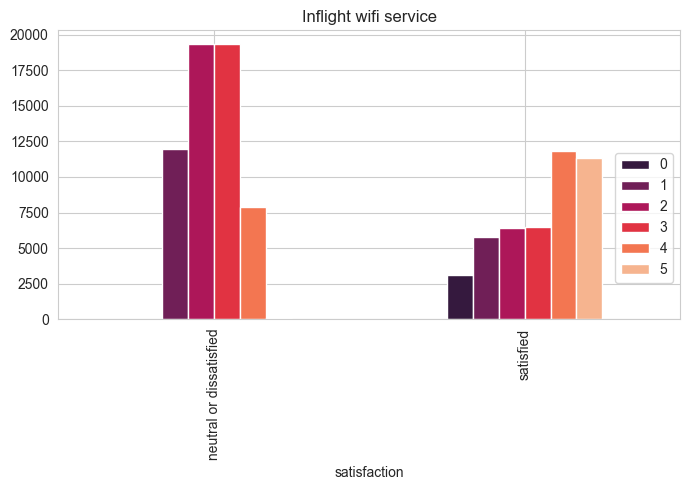

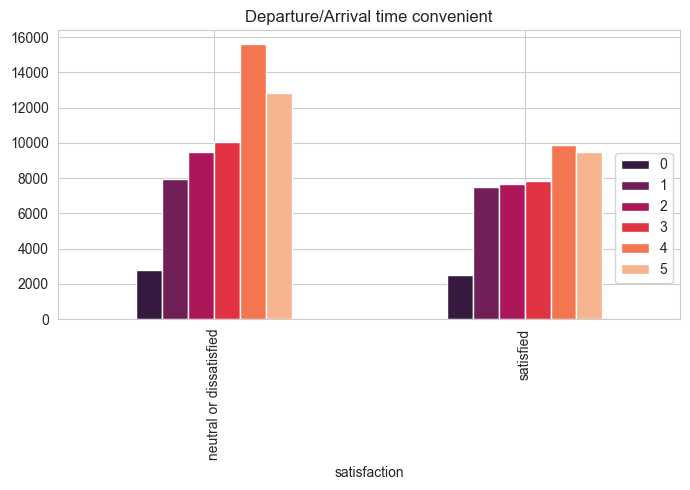

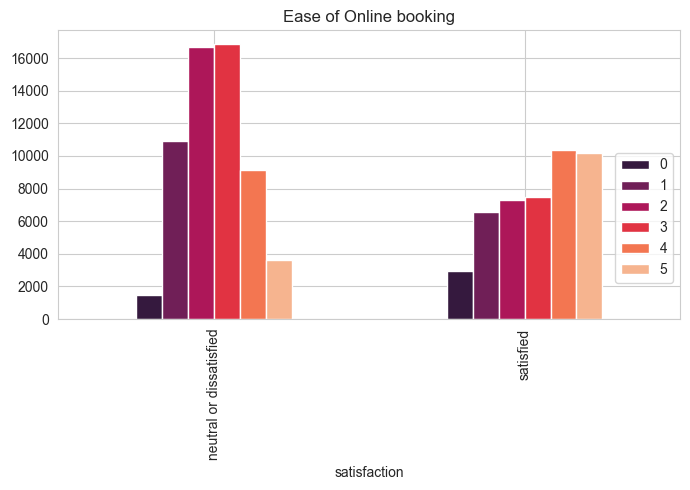

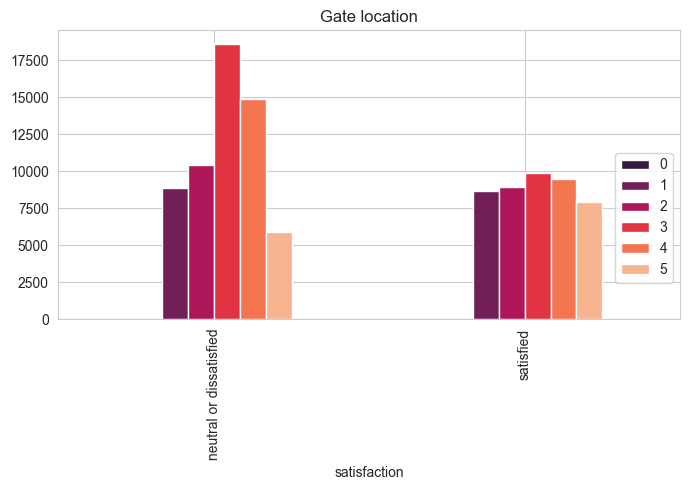

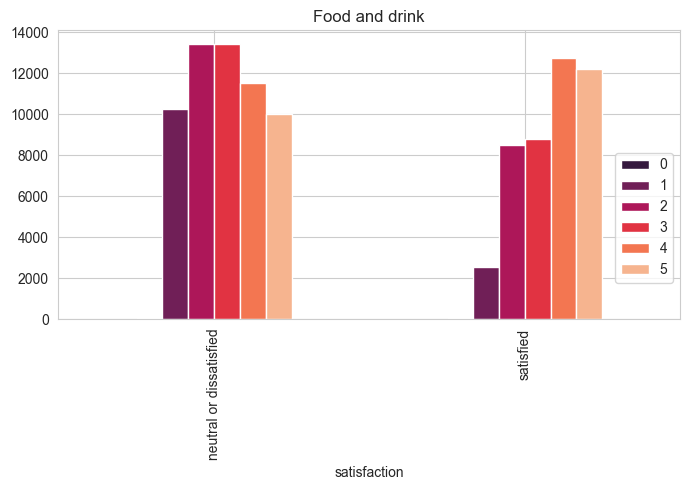

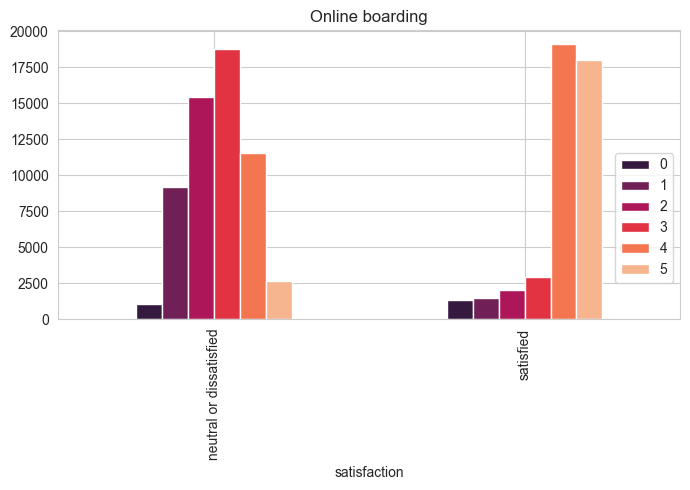

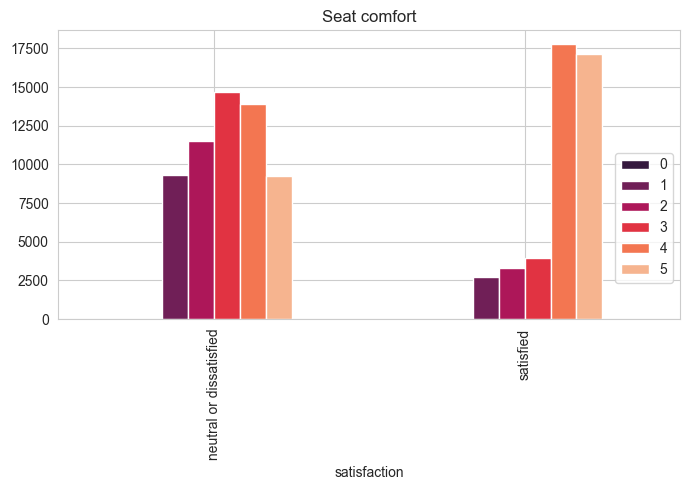

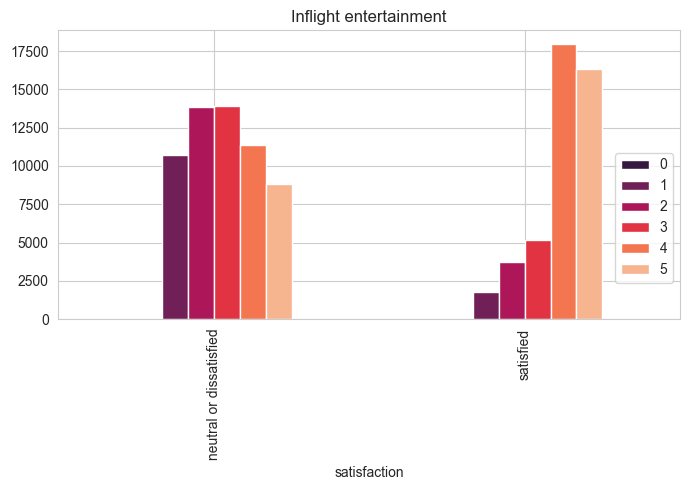

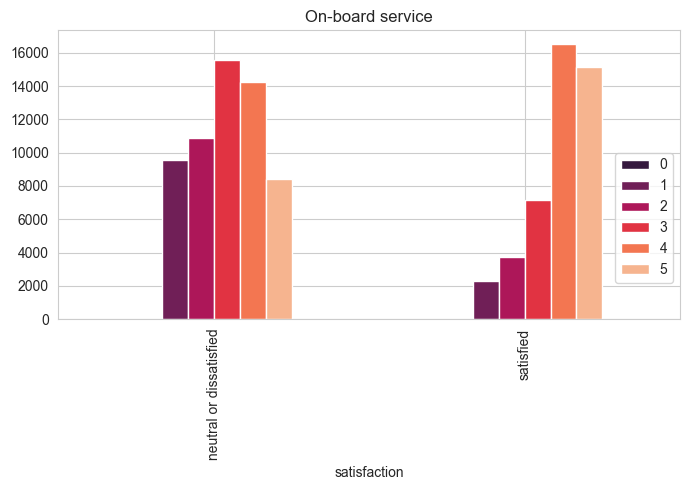

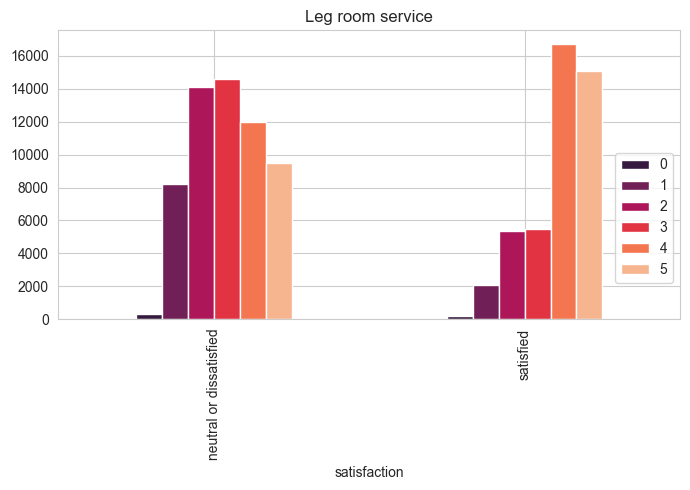

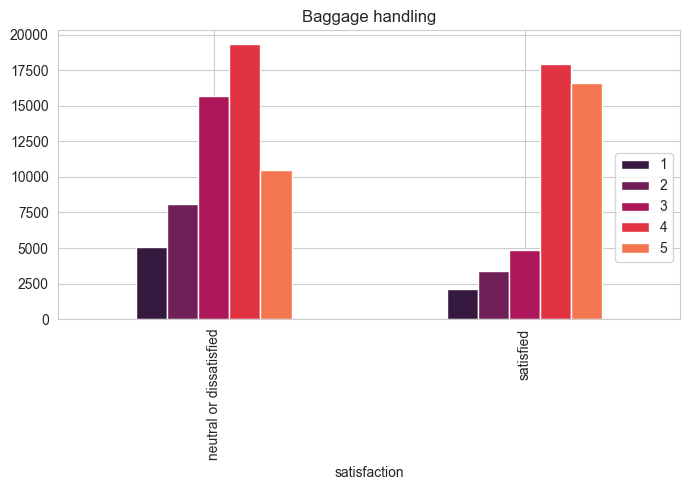

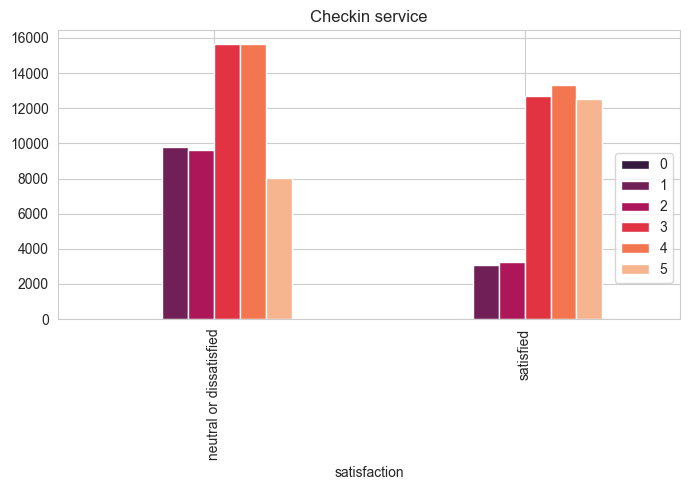

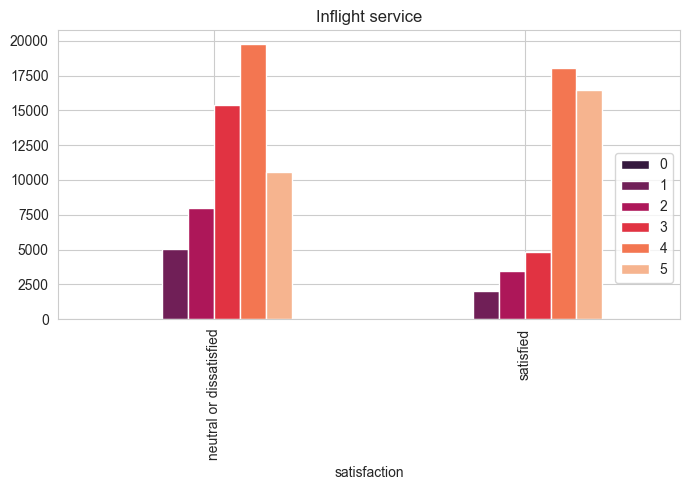

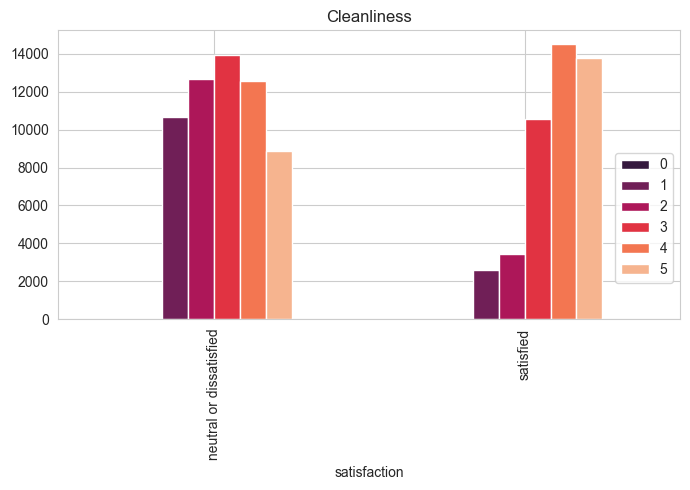

In [47]:
for i, col in enumerate(column_list_category[:-1]):
    if len(train_filt[col].value_counts()) >= 4:
        pd.crosstab(train_filt[col], train_filt["satisfaction"]).T.plot(kind='bar', figsize=(7, 5),
                                                                        color=sns.color_palette("rocket"))
        plt.legend(bbox_to_anchor=(1, 0.6))
        plt.title(col)
    plt.tight_layout(h_pad=2);

In [48]:
print(f'\033[1;35m Basic statistics for numerical columns:\033[1;0m\n')

for column in column_list_num:
    max_ = train[column].max()
    min_ = train[column].min()
    mean_ = train[column].mean()
    std_ = train[column].std()
    q0_25 = train[column].quantile(q=0.25)
    median_ = train[column].median()
    q0_75 = train[column].quantile(q=0.75)

    data_for_table.append([max_, min_, mean_, std_, q0_25, median_, q0_75])
    print(f"\033[1;35m{column}\033[0;0m")
    print(tabulate(data_for_table, headers=['Max', 'Min', 'Mean', 'Std', 'Q_0.25', 'Median', 'Q_0.75'],
                   tablefmt='rounded_outline') + '\n')
    data_for_table.clear()


 Basic statistics for numerical columns:

Age
╭───────┬───────┬─────────┬────────┬──────────┬──────────┬──────────╮
│   Max │   Min │    Mean │    Std │   Q_0.25 │   Median │   Q_0.75 │
├───────┼───────┼─────────┼────────┼──────────┼──────────┼──────────┤
│    85 │     7 │ 39.3797 │ 15.115 │       27 │       40 │       51 │
╰───────┴───────┴─────────┴────────┴──────────┴──────────┴──────────╯

Flight Distance
╭───────┬───────┬─────────┬─────────┬──────────┬──────────┬──────────╮
│   Max │   Min │    Mean │     Std │   Q_0.25 │   Median │   Q_0.75 │
├───────┼───────┼─────────┼─────────┼──────────┼──────────┼──────────┤
│  4983 │    31 │ 1189.45 │ 997.147 │      414 │      843 │     1743 │
╰───────┴───────┴─────────┴─────────┴──────────┴──────────┴──────────╯

Departure Delay in Minutes
╭───────┬───────┬─────────┬─────────┬──────────┬──────────┬──────────╮
│   Max │   Min │    Mean │     Std │   Q_0.25 │   Median │   Q_0.75 │
├───────┼───────┼─────────┼─────────┼──────────┼──────────┼───

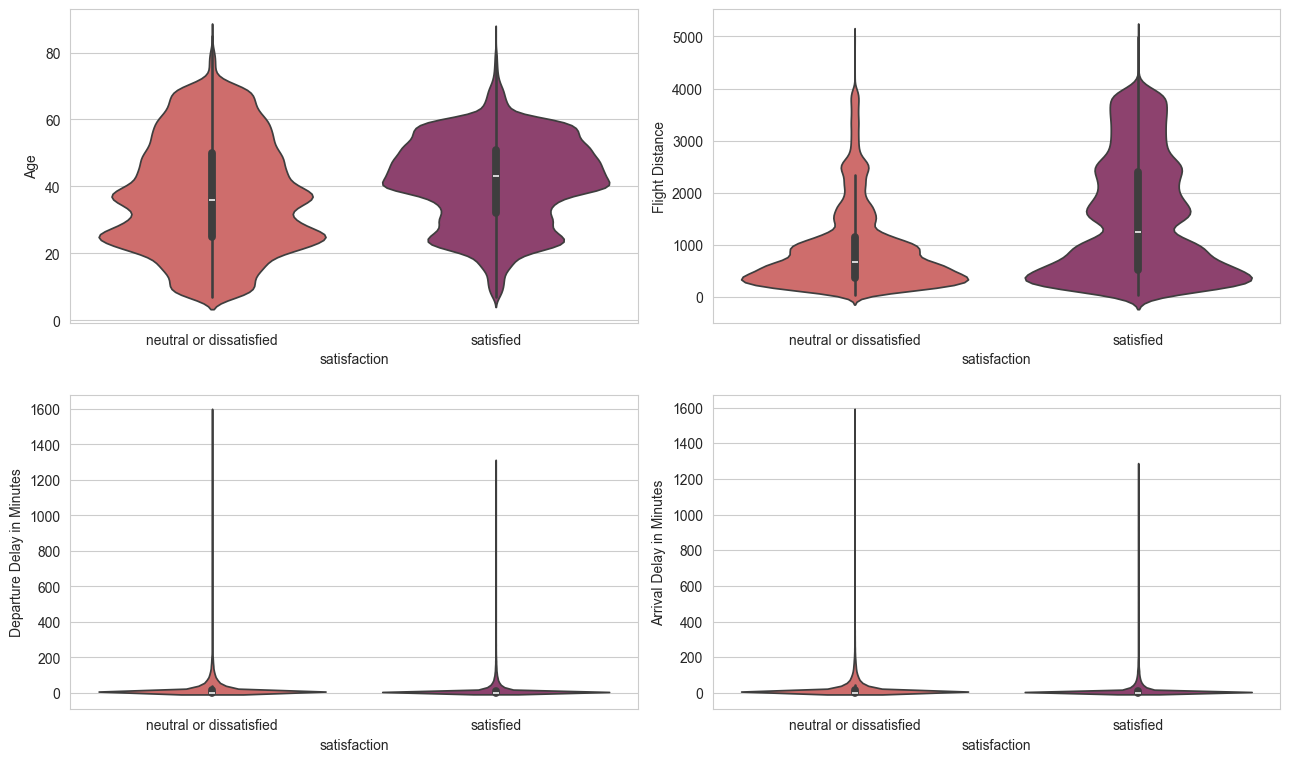

In [49]:
plt.figure(figsize=(13, 15))
#Теперь давайте посмотрим на распределение данных в численных колонках относительно колонки satisfaction
for i, col in enumerate(column_list_num):
    plt.subplot(4, 2, i + 1)
    sns.violinplot(train_filt, x='satisfaction', y=col, hue='satisfaction', color=sns.set_palette('flare', n_colors=2))
    plt.tight_layout(h_pad=2)
#Большой разницы нет

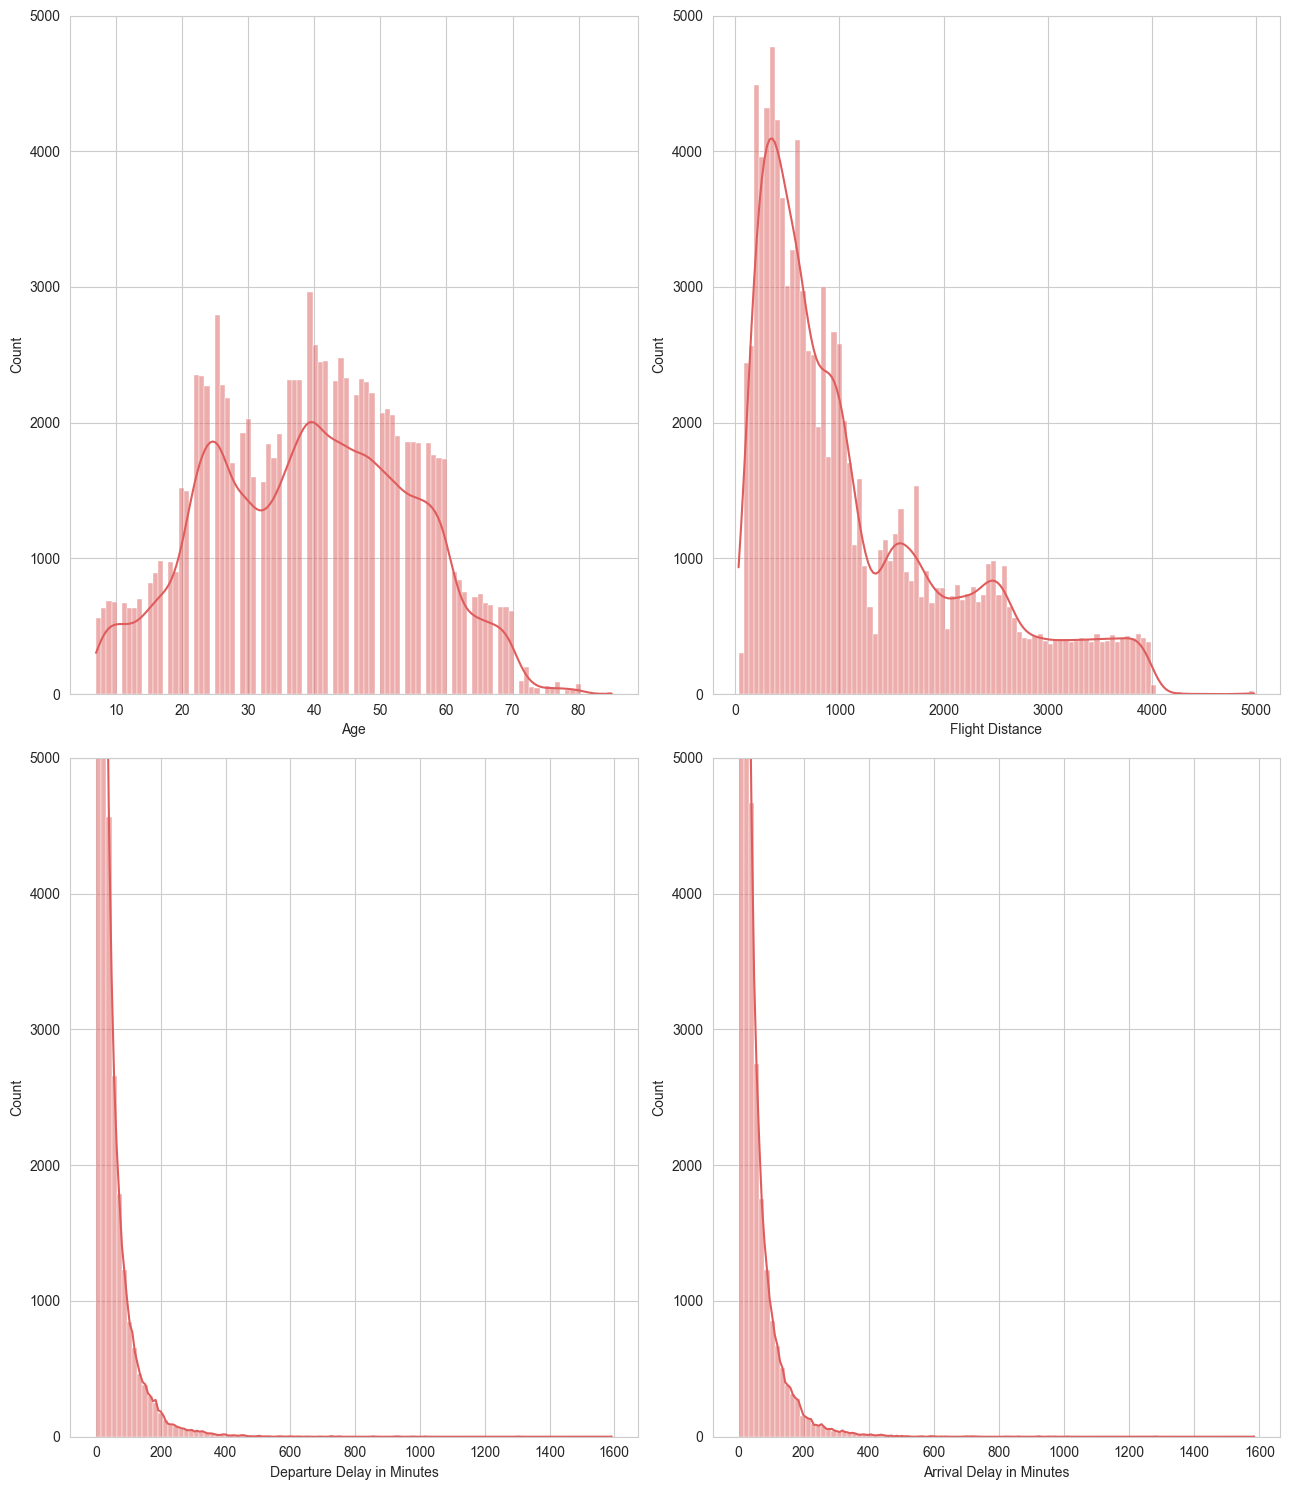

In [50]:
#Теперь посмотрим на корреляции между переменными, чтобы убрать мультиколлинеарность признаков в дальнейшем
#Для выбора метрики посмотрим на распределение переменных
plt.figure(figsize=(13, 15))
i = 1
for col in column_list_num:
    plt.subplot(2, 2, i)
    sns.histplot(train_filt[col], color=sns.set_palette('flare', n_colors=2), bins=100, kde=True)
    i += 1
    plt.ylim(0, 5000)

plt.tight_layout();


In [51]:
dict_0 = {'neutral or dissatisfied': 0, 'satisfied': 1}
train_filt = train_filt.replace({"satisfaction": dict_0})
test_filt = test_filt.replace({"satisfaction": dict_0})

/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_20644/1683423944.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_filt = train_filt.replace({"satisfaction": dict_0})
/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_20644/1683423944.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  train_filt = train_filt.replace({"satisfaction": dict_0})
/var/folders/7w/bn4plfg54bxf7fbpr3dxlsxc0000gn/T/ipykernel_20644/1683423944.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future vers

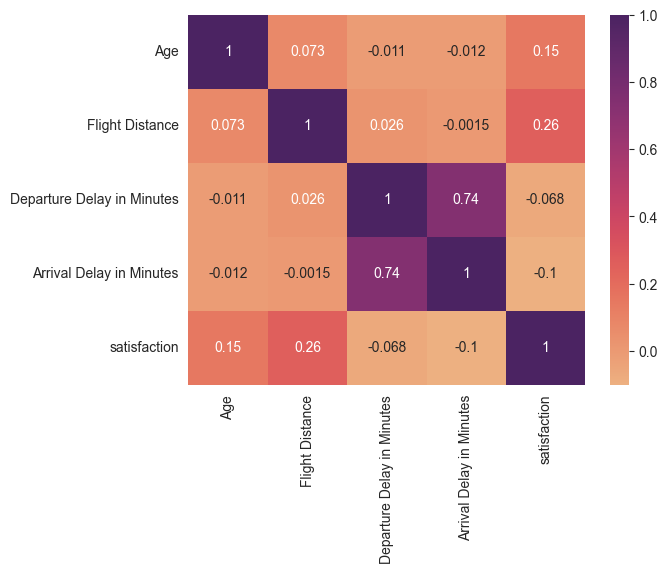

In [52]:
#Поскольку данные распределены ненормально будем использовать корреляцию Спирмена. Построим heatmap для визуализации
sns.heatmap(train_filt[['Age',
'Flight Distance',
'Departure Delay in Minutes',
'Arrival Delay in Minutes',
'satisfaction']].corr(method="spearman"), annot=True,
            cmap="flare");
#Переменные Departure Delay in Minutes и Arrival Delay in Minutes сильно коррелируют, надо подумать и может быть убрать одну из перемнных

In [116]:
X_train = train_filt.drop('satisfaction', axis=1)
X_test = test_filt.drop('satisfaction', axis=1)
y_train = train_filt["satisfaction"].values.astype("int8")
y_test = test_filt["satisfaction"].values.astype("int8")

## Логистическая регрессия

Accuracy =  0.932452786467385
Precision = 0.9317528735632183
Recall = 0.9129784425868895
F1_score = 0.922270121327941


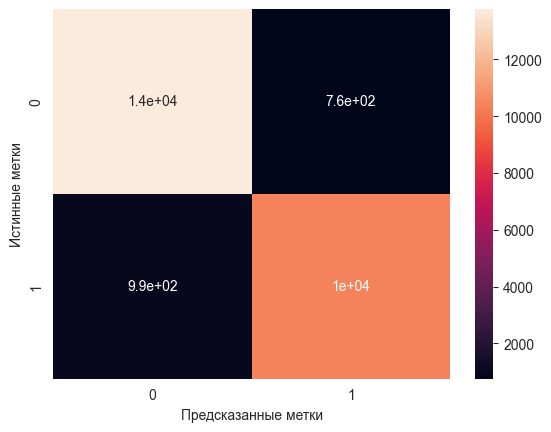

In [54]:
#Будем использовать OneHotEncoder для категориальных столбцов и StandardScaler для числовых
preprocessor = ColumnTransformer(transformers=[
    ("scaler", StandardScaler(), column_list_num),
    ("ohe", OneHotEncoder(), column_list_category[:-1])
])

#Создадим пайплайн
model_pipeline = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("model", LogisticRegression())
])

model_pipeline.fit(X_train, y_train)
predictions_proba = model_pipeline.predict_proba(X_test)
predictions = model_pipeline.predict(X_test)

print(f"Accuracy =  {accuracy_score(y_test, predictions)}")
print(f"Precision = {precision_score(y_test,predictions)}")
print(f"Recall = {recall_score(y_test,predictions)}")
print(f"F1_score = {f1_score(y_test,predictions)}")

sns.heatmap(confusion_matrix(y_test, predictions),
            annot=True).set(xlabel="Предсказанные метки", ylabel="Истинные метки");

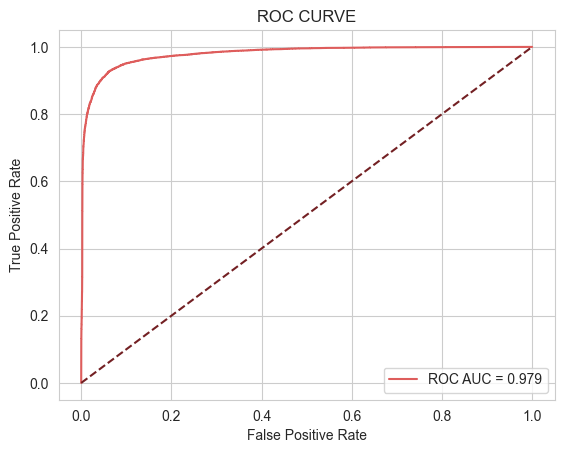

In [55]:
#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

In [56]:
#Для того, чтобы определить важность признаков, посмотрим на коэффициенты:
reg_model = model_pipeline.named_steps['model']

for feature, coef in zip(train_filt.columns,reg_model.coef_[0]):
    print(f"{feature}: {coef}")


Gender: -0.03192631075787656
Customer Type: 0.008721922074460245
Age: 0.19882827358158597
Type of Travel: -0.35045341316807943
Class: -0.2324207374113769
Flight Distance: -0.18666446866979902
Inflight wifi service: 1.4571147533441882
Departure/Arrival time convenient: -1.8761999594256957
Ease of Online booking: 1.9159241015643491
Gate location: -2.335009307645133
Food and drink: 0.35276378814822723
Online boarding: -0.2834939933802391
Seat comfort: -0.4883550008489524
Inflight entertainment: 8.513930073891556
On-board service: -3.2843116254897056
Leg room service: -3.5397848995416172
Baggage handling: -3.5887567271418073
Checkin service: -2.0333082798415263
Inflight service: 3.5131462520416137
Cleanliness: 0.03163705416725323
Departure Delay in Minutes: 0.33793062041050287
Arrival Delay in Minutes: 0.4566872483538347
satisfaction: 0.28634866428625166


## Дерево

Accuracy = 0.9481713204340941
Precision = 0.9472608544541388
Recall = 0.947549038608759
F1_score = 0.9474032423805734


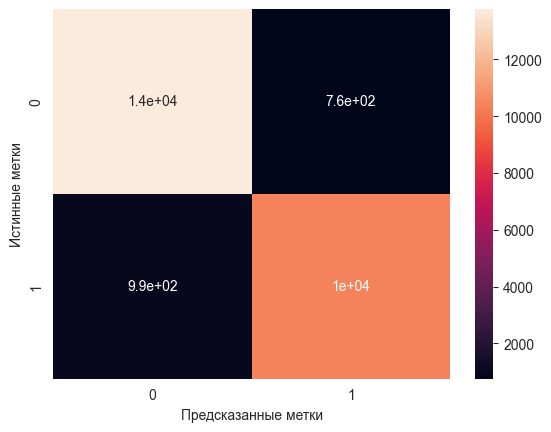

In [57]:
#Сделаем пайплайн
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model_tree', DecisionTreeClassifier())])
#Обучим модель и предскажем значения
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

sns.heatmap(confusion_matrix(y_test, predictions),
            annot=True).set(xlabel="Предсказанные метки", ylabel="Истинные метки");

# Лес

Accuracy = 0.961263661993589
Precision = 0.962573286043191
Recall = 0.9589000762639761
F1_score = 0.9605283810899545


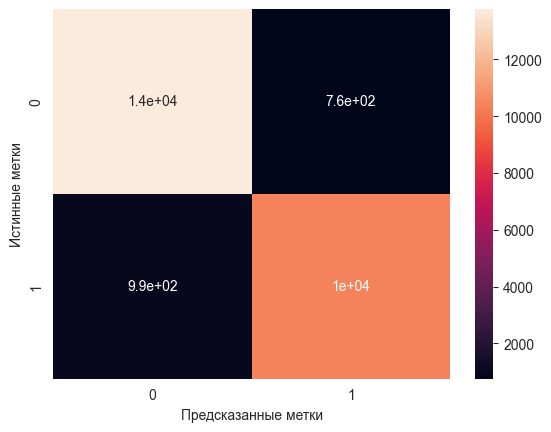

In [58]:
#Сделаем пайплайн
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model_tree', RandomForestClassifier(n_estimators=50, random_state=SEED))])
#Обучим модель и предскажем значения
model_pipeline.fit(X_train, y_train)
y_pred = model_pipeline.predict(X_test)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

sns.heatmap(confusion_matrix(y_test, predictions),
            annot=True).set(xlabel="Предсказанные метки", ylabel="Истинные метки");

In [ ]:
from sklearn.model_selection import cross_val_score

dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)

base_models = [("DT", dt), ("RF", rf),
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf)]

dict_for_dataframe = {0: [], 1: [], 2: [], 3: []}

for i, model in enumerate([dt, rf, svc_lin, svc_rbf, lr]):
    model_pipeline = Pipeline(steps=[('preprocessor', preprocessor), ('model_tree', model)])
    model_pipeline.fit(X_train, y_train)
    y_pred = model_pipeline.predict(X_test)
    scores = accuracy_score(y_test, y_pred)
    dict_for_dataframe[i] = scores
    print(scores)

In [ ]:
score_models = pd.DataFrame.from_dict(dict_for_dataframe, orient='columns')
score_models.columns = ['dt', 'rf', 'svc_lin', 'svc_rbf']
# Сделаем для наглядности график
ax = sns.boxplot(data=score_models, palette='flare')
plt.setp(ax.get_xticklabels(), rotation=90)
plt.xlabel("", size=20)
plt.ylabel("accuracy", size=20)
plt.title("accuracy для разных моделей", size=25)
plt.xticks(size=20)
plt.show()

# Naive baise classification

In [173]:
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB, CategoricalNB, BernoulliNB, MultinomialNB 

train_filt_lab = X_train.copy()
test_filt_lab = X_test.copy()


le = LabelEncoder()
for col in column_list_category[:-1]:
    train_filt_lab[col] = le.fit_transform(X_train[col])
    test_filt_lab[col] = le.fit_transform(X_test[col])
   

In [160]:
gnb = GaussianNB()
y_pred = gnb.fit(train_filt_lab, y_train).predict(test_filt_lab)
predictions_proba = gnb.predict_proba(test_filt_lab)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

Accuracy = 0.8631676514888194
Precision = 0.8689488654420765
Recall = 0.85423193902855
F1_score = 0.8587163479543201


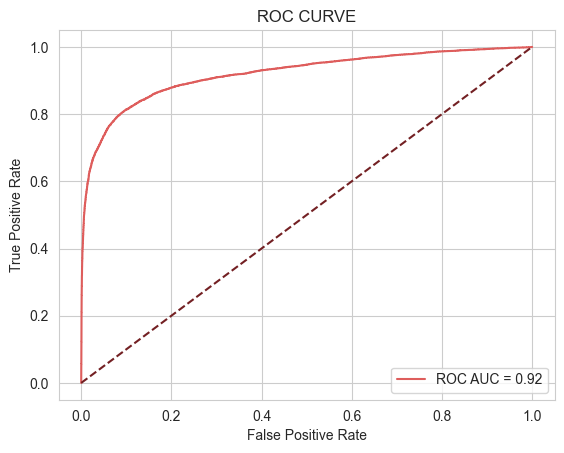

In [161]:
#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

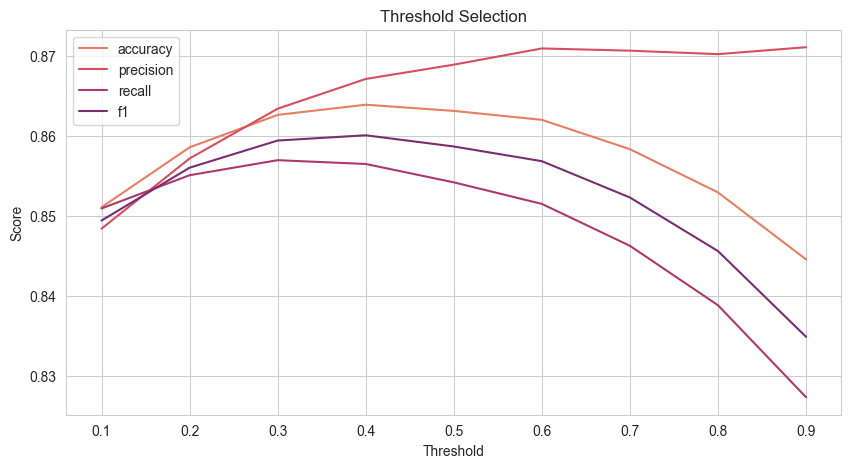

In [162]:
## calculate scores for different thresholds
'''
Определим, какие значения отсечки лучше всего для нашей модели.
Для этого построим график ("значение отсечки", "значение метрики") для каждой метрики accuracy, precision, recall, f1
'''
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}

predicted_prob = gnb.fit(train_filt_lab, y_train).predict_proba(test_filt_lab)[:,1]

thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(accuracy_score(y_test, predicted))
    dic_scores["precision"].append(precision_score(y_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(recall_score(y_test, predicted, average='macro'))
    dic_scores["f1"].append(f1_score(y_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax, color=sns.color_palette("flare", n_colors=4))
'''
отрисовываем
'''

plt.show()

In [163]:
import numpy as np
from sklearn.preprocessing import minmax_scale

train_filt_normalise = train_filt_lab.copy()
test_filt_normalise = test_filt_lab.copy()

train_filt_normalise[column_list_num] = minmax_scale(train_filt_normalise[column_list_num])
test_filt_normalise[column_list_num] = minmax_scale(test_filt_normalise[column_list_num])

In [167]:
# Что если нормализовать численные переменные

Accuracy = 0.8620862781446723
Precision = 0.8689048607095902
Recall = 0.8525690579024789
F1_score = 0.8573584637200404


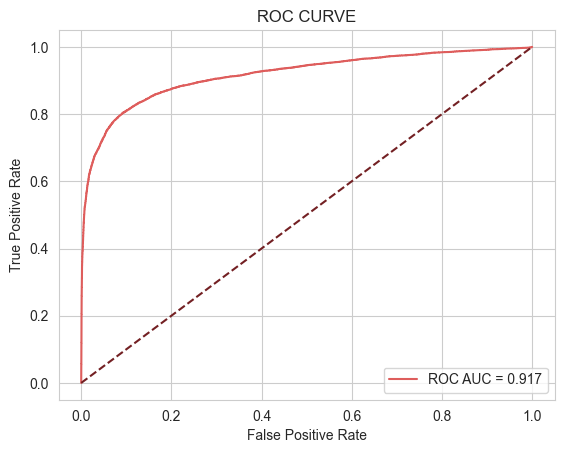

In [166]:
gnb = GaussianNB()
y_pred = gnb.fit(train_filt_normalise, y_train).predict(test_filt_normalise)
predictions_proba = gnb.predict_proba(test_filt_normalise)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

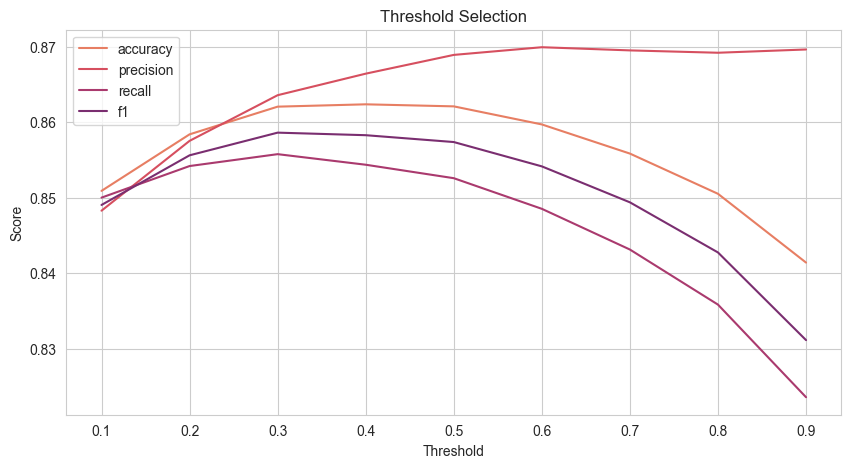

In [168]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}

predicted_prob = gnb.fit(train_filt_normalise, y_train).predict_proba(test_filt_normalise)[:,1]

thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(accuracy_score(y_test, predicted))
    dic_scores["precision"].append(precision_score(y_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(recall_score(y_test, predicted, average='macro'))
    dic_scores["f1"].append(f1_score(y_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax, color=sns.color_palette("flare", n_colors=4))
'''
отрисовываем
'''

plt.show()

Accuracy = 0.8921716293979067
Precision = 0.8943315095651106
Recall = 0.8866685336966613
F1_score = 0.8895744337502471


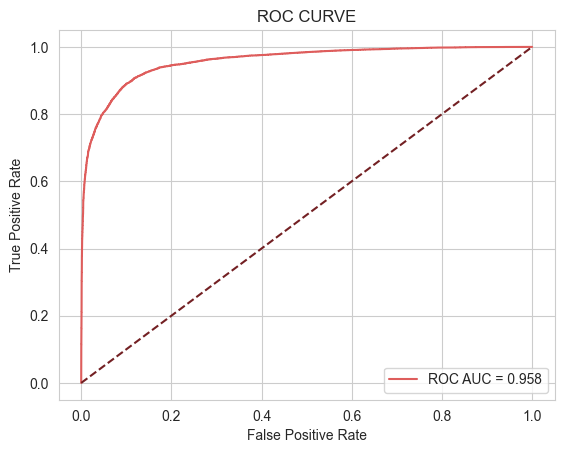

In [171]:
gnb = CategoricalNB()
y_pred = gnb.fit(train_filt_lab, y_train).predict(test_filt_lab)
predictions_proba = gnb.predict_proba(test_filt_lab)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

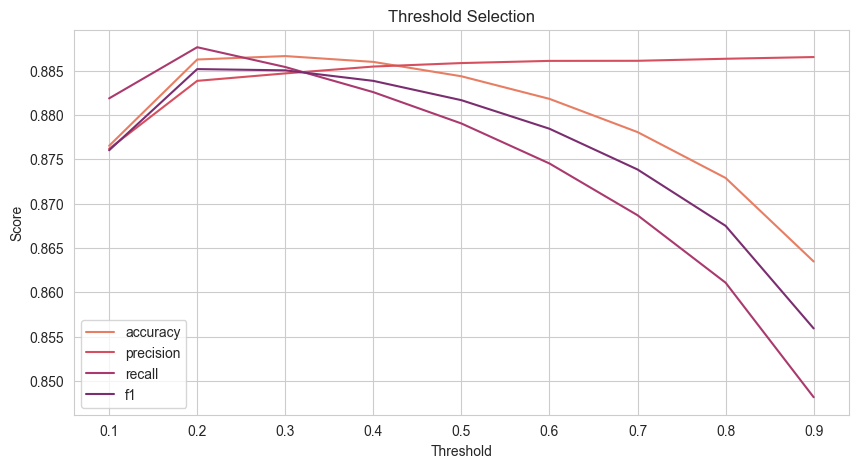

In [172]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10,5),dpi=100)

dic_scores = {'accuracy':[], 'precision':[], 'recall':[], 'f1':[]}

predicted_prob = gnb.fit(train_filt_normalise, y_train).predict_proba(test_filt_normalise)[:,1]

thresholds = []
for threshold in np.arange(0.1, 1, step=0.1):
    predicted = (predicted_prob > threshold)
    thresholds.append(threshold)
    dic_scores["accuracy"].append(accuracy_score(y_test, predicted))
    dic_scores["precision"].append(precision_score(y_test, predicted, average='macro', zero_division=1))
    dic_scores["recall"].append(recall_score(y_test, predicted, average='macro'))
    dic_scores["f1"].append(f1_score(y_test, predicted, average='macro'))
'''
Добавим линии
'''
## plot
dtf_scores = pd.DataFrame(dic_scores).set_index(pd.Index(thresholds))
ax.set(xlabel='Threshold', ylabel="Score", title="Threshold Selection")
dtf_scores.plot(ax=ax, color=sns.color_palette("flare", n_colors=4))
'''
отрисовываем
'''

plt.show()

Accuracy = 0.7787819101687715
Precision = 0.7768498011386303
Recall = 0.780631920810472
F1_score = 0.7773492857708166


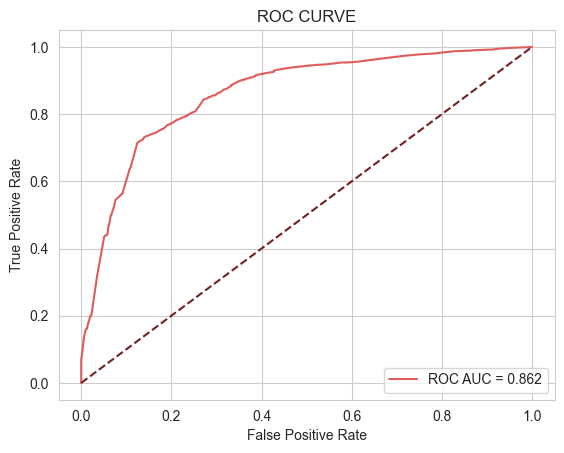

In [174]:
gnb = BernoulliNB()
y_pred = gnb.fit(train_filt_lab, y_train).predict(test_filt_lab)
predictions_proba = gnb.predict_proba(test_filt_lab)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");

Accuracy = 0.6021318503070328
Precision = 0.6001319295430545
Recall = 0.6015262213137949
F1_score = 0.5996687928083255


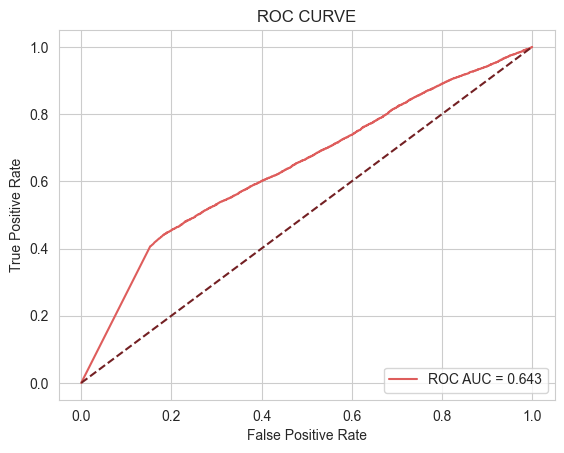

In [175]:
gnb = MultinomialNB()
y_pred = gnb.fit(train_filt_lab, y_train).predict(test_filt_lab)
predictions_proba = gnb.predict_proba(test_filt_lab)

#Посмотрим на метрики
print(f'\033[1;36mAccuracy = \033[0m{accuracy_score(y_test, y_pred)}')
print(f'\033[1;36mPrecision = \033[0m{precision_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mRecall = \033[0m{recall_score(y_test, y_pred, average="macro")}')
print(f'\033[1;36mF1_score = \033[0m{f1_score(y_test, y_pred, average="macro")}')

#Построим ROC кривую
fpr, tpr, thresholds = roc_curve(y_test, predictions_proba[:, 1])
plt.plot(fpr, tpr, label = f"ROC AUC = {round(roc_auc_score(y_test, predictions_proba[:, 1]),3)}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC CURVE")
plt.plot([0, 1], [0, 1], color= '#732023', linestyle='--')
plt.legend(loc="lower right");